In [1]:
from qiskit_ibm_runtime import RuntimeDecoder
import json
from magnetization import *
import numpy as np
import matplotlib.pyplot as plt

lamb = 0.5
lamb_tag = "0_5"
T = 2
delta_t = T/200

results = []

#Extraction of the stored data of the simulation
with open("results/result_lambda_"+lamb_tag+".json", "r") as file:
    job = json.load(file, cls=RuntimeDecoder)
t_axis = np.loadtxt("results/times_lambda_"+lamb_tag+".txt")
for i in range(len(job)):
    results.append(job[i].data.meas.get_bitstrings())
results = np.array(results)

In [2]:
#Calculation of the statistics
Mz_list = np.array([])
stdv_list = np.array([])
stdv_mean_list = np.array([])

for result in results:
    Mz, stdv, stdv_mean = Mz_statistics(result)
    Mz_list = np.append(Mz_list,Mz)
    stdv_list = np.append(stdv_list,stdv)
    stdv_mean_list = np.append(stdv_mean_list,stdv_mean)
print("Number of times:",len(t_axis))
print("Number of magnetizations:",len(Mz_list))

Number of times: 20
Number of magnetizations: 20


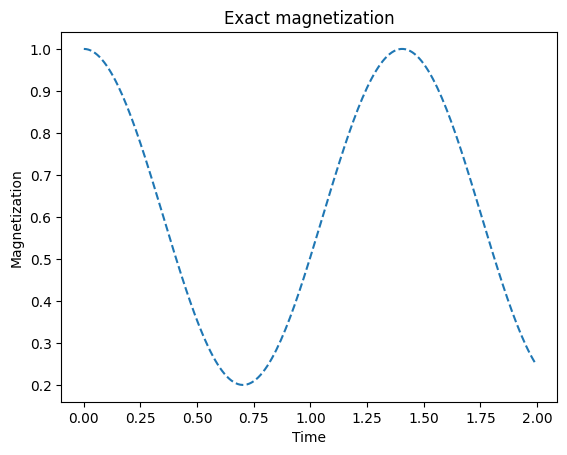

In [3]:
#Printout of the exact magnetization
Mz_exact, t_axis_exact = get_data_Mz(T,delta_t,lamb)

plt.plot(t_axis_exact,Mz_exact,'--')
plt.title("Exact magnetization")
plt.xlabel("Time")
plt.ylabel("Magnetization")

plt.show()

Reduced chi2: 60.668227266670485


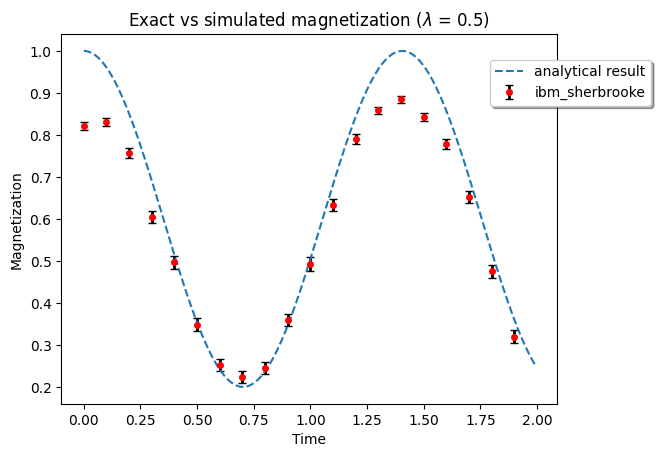

In [4]:
#Comparison of the simulation with the exact result
plt.errorbar(t_axis,Mz_list,yerr=stdv_mean_list,fmt='ro',label="ibm_sherbrooke", markersize="4", elinewidth=2, ecolor="black", capsize=3)
plt.plot(t_axis_exact,Mz_exact,'--',label="analytical result")
plt.title("Exact vs simulated magnetization (" + r"$\lambda$" + " = " + str(lamb) + ")")
plt.xlabel("Time")
plt.ylabel("Magnetization")
plt.legend(bbox_to_anchor=(0.85,0.95),fancybox=True,shadow=True,fontsize=10)
plt.savefig("QC_graphs/QC_graph_lambda_" + lamb_tag, bbox_inches="tight")

#Computation of the reduced chi^2
s = 0
for i in range(len(Mz_list)):
    s += (Mz_list[i] - get_Mz(t_axis[i],lamb))**2 / (stdv_mean_list[i]**2)
red_chi2 = s/len(Mz_list)
print("Reduced chi2:",red_chi2)

plt.show()

In [5]:
#Interpolation
f = lambda t, a, b: (1+2*lamb**2+a*np.cos(4*t*np.sqrt(1+lamb**2))) / (2+2*lamb**2) + b
f_err = lambda t, a_err, b_err: np.sqrt( ((a_err*np.cos(4*t*np.sqrt(1+lamb**2))) / (2+2*lamb**2))**2 + b_err**2 )

a_value, a_err, b_value, b_err, chi2, ndof = interpolation(t_axis, Mz_list, stdv_mean_list, f)

#Printout of the result of the interpolation
print("Estimated a:", a_value)
print("Estimated uncertainty on a:", a_err)
print("Estimated b:", b_value)
print("Estimated uncertainty on b:", b_err)
print("Chi2 on the interpolation:", chi2)
print("Number of degrees of freedom:", ndof)
print("Reduced chi2:", chi2/ndof)

est_Mz = np.array([])
est_err = np.array([])

for i in range(len(t_axis_exact)):
    t = t_axis_exact[i]
    est_Mz = np.append(est_Mz,f(t,a_value,b_value))
    if t in t_axis:
        est_err = np.append(est_err,f_err(t,a_err,b_err))
    else:
        est_err = np.append(est_err,0)

Estimated a: 0.8111442155043308
Estimated uncertainty on a: 0.00996017112005086
Estimated b: -0.048788587326973804
Estimated uncertainty on b: 0.0030793007692423674
Chi2 on the interpolation: 70.59174119852901
Number of degrees of freedom: 18.0
Reduced chi2: 3.9217633999182784


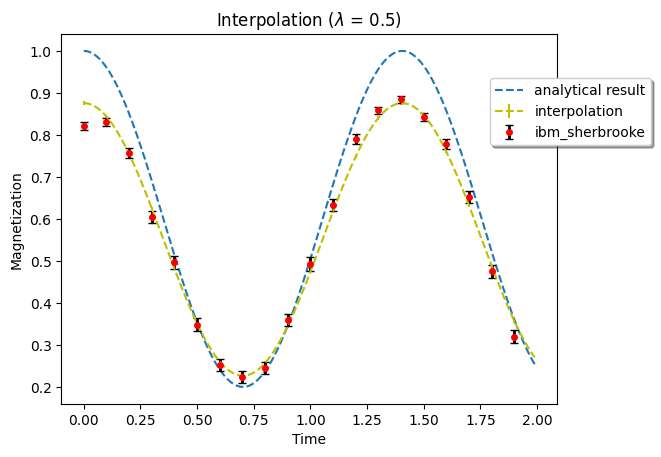

In [6]:
#Plot of the exact magnetization, the simulated one and the interpolation
plt.plot(t_axis_exact,Mz_exact,'--',label="analytical result")
plt.errorbar(t_axis_exact,est_Mz,yerr=est_err,fmt='--y',label="interpolation")
plt.errorbar(t_axis,Mz_list,yerr=stdv_mean_list,fmt='ro',label="ibm_sherbrooke", markersize="4", elinewidth=2, ecolor="black", capsize=3)
plt.title("Interpolation (" + r"$\lambda$" + " = " + str(lamb) + ")")
plt.xlabel("Time")
plt.ylabel("Magnetization")
plt.legend(bbox_to_anchor=(0.85,0.9),fancybox=True,shadow=True,fontsize=10)
plt.savefig("QC_graphs/QC_interpolation_lambda_" + lamb_tag, bbox_inches="tight")

plt.show()